In [1]:
import os
import sys
sys.path.insert(0,'/home/junwoony/Desktop/Differentiable_Optimization_GCN/Differentiable_Optimization_GCN/')

import numpy as np
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1

import mongo
import time
import pickle
import random
import numpy as np
import tqdm
import copy
import matplotlib.pyplot as plt
import multiprocess as mp
import seaborn as sns
import pandas as pd
from pymatgen.io.ase import AseAtomsAdaptor

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lbfgs import LBFGS
from cgcnn.data_orbital import StructureData, ListDataset, StructureDataTransformer, collate_pool, MergeDataset
from cgcnn.model import CrystalGraphConvNet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import get_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
import skorch.callbacks.base
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

from utils.adamwr.adamw import AdamW
from utils.adamwr.cosine_scheduler import CosineLRWithRestarts


from sigopt_sklearn.search import SigOptSearchCV


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
SDT_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/SDT_list.pkl', 'rb'))
docs = pickle.load(open('../../../cgcnn/bond_regression3/new2/final_docs.pkl', 'rb'))

# SDT_list = pickle.load(open('../../../cgcnn/bond_regression3/new3/SDT_list.pkl', 'rb'))
# docs = pickle.load(open('../../../cgcnn/bond_regression3/new3/final_docs.pkl', 'rb'))

# target_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/target_list.pkl', 'rb'))
# target_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/target_list_mse.pkl', 'rb'))

structures = SDT_list[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]



In [3]:
# target_list = []
# for i, sdt in enumerate(SDT_list):
#     atom_pos_final = sdt[-1]
#     nbr_fea_idx = sdt[2]
#     nbr_fea_offset = sdt[3]
#     cells = sdt[7]
    
#     nbr_pos = atom_pos_final[nbr_fea_idx]
#     differ = nbr_pos - atom_pos_final.unsqueeze(1) + torch.bmm(nbr_fea_offset, cells)
#     differ_sum = torch.sum(differ**2, dim=2)
#     distance = torch.sqrt(differ_sum).unsqueeze(-1)
    
#     if np.min(distance.numpy()) == 0:
#         print(i)
#     else:
#         target_list.append(distance.numpy())
# target_list = np.array(target_list).reshape(-1,1)

In [4]:
# np.concatenate(target_list.reshape(-1)).shape

In [5]:
# (atom_fea, nbr_fea, nbr_fea_idx, nbr_fea_offset, atom_pos, nbr_pos, atom_pos_idx, cells, fixed_atom_idx, atom_pos_final)
atom_fea = SDT_list[0][0]
nbr_fea = SDT_list[0][1]
nbr_fea_idx = SDT_list[0][2]
nbr_fea_offset = SDT_list[0][3]
atom_pos =SDT_list[0][4]
nbr_pos = SDT_list[0][5] 
atom_pos_idx = SDT_list[0][6]
cells = SDT_list[0][7]
fixed_base = SDT_list[0][8]
free_atom_idx = SDT_list[0][9]
atom_pos_final = SDT_list[0][10]
# atom_pos_final_free = SDT_list[0][11]
target_list = np.array([sdt[-1][sdt[9]].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY

In [6]:
SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
= train_test_split(SDT_list, target_list, docs, test_size=0.1, random_state=42)

In [7]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='./new_backup3/valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./new_backup3/valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device:', device)

device: cuda


In [8]:
def get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells):
    nbr_pos = atom_pos[nbr_fea_idx]
    differ = nbr_pos - atom_pos.unsqueeze(1) + torch.bmm(nbr_fea_offset, cells)
    differ_sum = torch.sum(differ**2, dim=2)
    distance = torch.sqrt(differ_sum).unsqueeze(-1)            
    return distance
differences = []
c = 0
max_num_nbr = 12

for sdt in SDT_list:
    nbr_fea_idx = sdt[2]
    nbr_fea_offset = sdt[3]
    atom_pos =sdt[4]
    cells = sdt[7]
    atom_pos_final = sdt[-1]
    free_atom_idx = sdt[-2]
#     bond_distance = get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells)[free_atom_idx]
#     final_distance = get_distance(atom_pos_final, nbr_fea_idx, nbr_fea_offset, cells)[free_atom_idx]
#     c += len(atom_pos[free_atom_idx])*12
    bond_distance = get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells)
    final_distance = get_distance(atom_pos_final, nbr_fea_idx, nbr_fea_offset, cells)
    N, M, C = bond_distance.shape
    bond_distance = bond_distance #* fake_nbr.float().expand(N, M, C)    
    final_distance = final_distance #* fake_nbr.float().expand(N, M, C) 
    
    c += len(atom_pos) * max_num_nbr
    differences.append((final_distance - bond_distance).view(-1))
differences = torch.cat(differences)**2
# differences = torch.clamp(differences, min=1e-8)
assert c == len(differences)
# dist_err = torch.mean(torch.abs(differences))
# torch.log(dist_err)
# dist_err = torch.mean(torch.sqrt(differences))
dist_err = torch.mean(torch.abs(differences))
dist_err


tensor(0.0059)

In [9]:
def diff(sdt, target):
    fixed_base = sdt[8]
    free_atom_idx = np.where(fixed_base == 0)[0]
    free_atom_idx = torch.LongTensor(free_atom_idx)   
    diff = np.sum(((target[0] - sdt[4].numpy()[free_atom_idx]))**2.,axis=1)**0.5 
    return diff

np.mean(np.abs(np.concatenate([diff(sdt, target) for sdt,target in zip(SDT_test, target_test)])))

0.13144483

In [10]:
def diff_position(sdt, target):
    fixed_base = sdt[8]
    free_atom_idx = np.where(fixed_base == 0)[0]
    free_atom_idx = torch.LongTensor(free_atom_idx)   
    diff = (target[0] - sdt[4].numpy()[free_atom_idx])
    return diff

differences = []
for sdt, target in zip(SDT_test, target_test):
    differences.append(diff_position(sdt, target))
differences = np.concatenate(differences)
np.mean(np.abs(differences))

0.059913088

In [16]:
from torch.optim import lr_scheduler
import torch.optim as optim


# train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
# train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=32)



batchsize = 17
# warm restart scheduling from https://arxiv.org/pdf/1711.05101.pdf
# LR_schedule = LRScheduler(CosineLRWithRestarts, batch_size=batchsize, epoch_size=len(SDT_training), restart_period=10, t_mult=1.2)

#### For Sigopt
LR_schedule = LRScheduler("MultiStepLR", milestones=[100], gamma=0.1)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        differ=torch.sum((y_pred-y_true.cuda())**2.0,dim=1)
        if torch.nonzero(differ).shape[0] != differ.shape[0]:
            print('zero sqrt for Loss')
#             zero_idx = (differ == 0).nonzero()
#             differ[zero_idx] = 1e-6
        differ = torch.clamp(differ, min=1e-8)

        return torch.mean(torch.sqrt(differ))


net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=batchsize, #214
    module__classification=False,
    lr=0.0393415,
    max_epochs= 200,
    module__energy_mode="Harmonic", #["Harmonic", "Morse", "LJ"], Default = "Harmonic"
    module__atom_fea_len=236, #46,
    module__h_fea_len=6,
    module__h_fea_len_dist=4,
    module__h_fea_len_const=4,
#     module__h_fea_len_D=(3,256),
    module__n_conv=12, #8
    module__n_h_dist=0,
    optimizer__weight_decay=0.0000454,
    module__n_h_const=0,
#     module__n_h_D=(1,12),
#     module__max_num_nbr=12, #9
#     module__opt_step_size=(0.1,0.7), #0.3
    module__min_opt_steps=30,
    module__max_opt_steps=150,
    module__momentum=0.8,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp,LR_schedule , load_best_valid_loss],

)


net.initialize()
net.load_params(f_history = './new_backup3/valid_best_history.json',
               f_optimizer = './new_backup3/valid_best_optimizer.pt',
               f_params = './new_backup3/valid_best_params.pt')

In [14]:
# net.initialize()
# net.fit(SDT_training, target_training)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, energy_mode, h_fea_len, h_fea_len_const, h_fea_len_dist, max_opt_steps, min_opt_steps, momentum, n_conv, n_h_const, n_h_dist, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer because the following parameters were re-set: weight_decay.


/home/junwoony/miniconda3/envs/schnet2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  epoch    train_loss    valid_loss    cp       dur
-------  ------------  ------------  ----  --------
      1        0.1290        0.1129     +  264.7279
      2        0.1123        0.1039     +  270.8974
      3        0.1050        0.0974     +  267.6029
      4        0.1033        0.0961     +  260.2854
blow up
blow up
blow up
      5        0.1000        0.1239        252.3720
      6        0.1006        0.1009        257.8019
      7        0.0967        0.0952     +  254.6884
      8        0.0929        0.0983        255.4818
      9        0.0905        0.0872     +  247.9439
     10        0.0907        0.0835     +  252.3809
     11        0.0880        0.0827     +  252.9848
     12        0.0881        0.0864        250.6565
     13        0.0879        0.0873        247.4375
blow up
blow up
blow up
blow up
blow up
blow up
blow up
     14        0.0879        0.0963        246.2459
     15        0.0863        0.0857        250.2369
     16        0.0812        0.0983 

    136        0.0279        0.0605        259.0483
    137        0.0278        0.0602        258.9218
    138        0.0285        0.0601        260.6545
    139        0.0280        0.0605        257.7755
    140        0.0276        0.0599        257.5738
    141        0.0273        0.0613        260.2245
    142        0.0271        0.0605        259.4908
    143        0.0278        0.0600        260.2902
    144        0.0273        0.0606        259.6179
    145        0.0282        0.0606        259.9196
    146        0.0271        0.0609        259.2731
    147        0.0272        0.0606        260.3694
    148        0.0267        0.0604        261.3831
    149        0.0269        0.0613        260.6137
    150        0.0266        0.0601        260.7742
    151        0.0267        0.0604        261.6491
    152        0.0263        0.0603        261.9023
    153        0.0263        0.0604        260.6053
    154        0.0264        0.0600        262.1631
    155     

<class '__main__.MyNet'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=140, out_features=236, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=499, out_features=472, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): LeakyReLU(negative_slope=0.01)
        (bn1): BatchNorm1d(472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(236, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): LeakyReLU(negative_slope=0.01)
        (fc_full2): Linear(in_features=499, out_features=54, bias=True)
        (nbr_bn1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (nbr_bn2): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=499, out_features=472, bias=True)
        (sigmoid): Sigmoid()
        (softpl

In [17]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
SDT_test_new, target_test_new= [], []
print(len(docs_test), len(SDT_test), len(target_test))
for i, doc in enumerate(docs_test):
    sdt = SDT_test[i]
    target = target_test[i]

    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    
    if np.mean(dist) > 0.06:
        distances.append(dist)
        filtered_idx.append(doc['idx'])
        
        SDT_test_new.append(sdt)
        docs_test_new.append(doc)
        target_test_new.append(target)

docs_test = docs_test_new
SDT_test = SDT_test_new
target_test = target_test_new
print(len(docs_test), len(SDT_test), len(target_test))


601 601 601
601 601 601


In [18]:
# SDT_train, SDT_valid, target_train, target_valid = train_test_split(SDT_training, target_training, 
#                                                                     test_size=0.1, random_state=42)
def get_targets(dummy_SDT, dummy_targets):
    targets = []
    for i, target in enumerate(dummy_targets):
        free_atom_idx = dummy_SDT[i][-2]
        targets.append(target[0].reshape(-1,3))
    return np.concatenate(targets)

def get_distance(pred, true):
    diff = np.sum((pred - true)**2, axis=1)
    return np.sqrt(diff)

def get_initial(SDT_list):
    init_test = []
    for sdt in SDT_list:
        free_atom_idx = sdt[-2]
        atom_pos = sdt[4][free_atom_idx]
        init_test.append(atom_pos)
    return np.concatenate(init_test)
        

In [21]:
# init_test = get_initial(SDT_test)
# pred_test = net.predict(SDT_test)
# true_test = get_targets(SDT_test, target_test)

init_test = pickle.load(open('./new_backup3/init_test.pkl', 'rb'))
pred_test = pickle.load(open('./new_backup3/pred_test.pkl', 'rb'))
true_test = pickle.load(open('./new_backup3/true_test.pkl', 'rb'))

torch.cuda.empty_cache()

distance_test = get_distance(pred_test, true_test)
distance_pred_initial = get_distance(pred_test, init_test)
distance_init = get_distance(init_test, true_test)

###### Per ATOM MAE ##### (NOT per structure MAE)

MAE_pred_final = np.mean(distance_test)
MAE_pred_initial = np.mean(distance_pred_initial)
MAE_initial_final = np.mean(distance_init)

In [20]:
# pickle.dump(init_test, open('./new_backup3/init_test.pkl', 'wb'))
# pickle.dump(pred_test, open('./new_backup3/pred_test.pkl', 'wb'))
# pickle.dump(true_test, open('./new_backup3/true_test.pkl', 'wb'))

In [22]:
#### RMSD ####
RMSD_init = np.sqrt(np.mean(np.sum((init_test - true_test)**2, axis=1)))
RMSD_pred = np.sqrt(np.mean(np.sum((pred_test - true_test)**2, axis=1)))
print(RMSD_init, RMSD_pred, RMSD_pred/RMSD_init)

0.17722969 0.09216244 0.5200169


In [23]:
print(MAE_pred_final, MAE_pred_initial, MAE_initial_final)
print(MAE_pred_final/MAE_initial_final, 1 - MAE_pred_final/MAE_initial_final)

0.06305466 0.11878607 0.1383077
0.45590127 0.5440987348556519


Text(0.5, 1.0, 'test result')

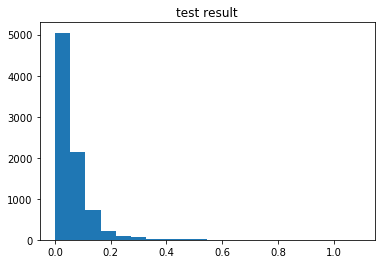

In [20]:
plt.hist(distance_test, bins=20)
plt.title('test result')

In [18]:
docs_train, docs_val = train_test_split(docs_training, test_size=0.1, random_state=42)

In [30]:
def analysis(SDT, docs, distance):
    dist_per_surface = []
    init_dist_per_surface = []
    total_atoms = 0
    for i in range(len(SDT)):
        doc = docs[i]
        sdt = SDT[i]
        
        num_atoms = sdt[-2].shape[0]
        dist_per_surface.append(np.mean(distance[total_atoms: total_atoms+num_atoms]))
        total_atoms += num_atoms
        init_dist = torch.sqrt(torch.sum(((sdt[4] - sdt[-1])[sdt[-2]]**2), dim=1))
        init_dist_per_surface.append(torch.mean(init_dist))
        
    assert len(distance) == total_atoms
    results =[]
    reduced = []
    best = []
    bad_result =[]
    good_result=[]
    bad_docs = []
    good_docs = []
    test_idx = 0
    MAE, MAE_pos = [], []
    for dist, doc, init_dist in zip(dist_per_surface, docs, init_dist_per_surface):
        if doc['idx'] in filtered_idx:

            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
            base = np.zeros_like(atoms.positions)
            base[atoms.constraints[0].get_indices()] = 1
            free_atom_idx = np.where(base == 0)[0]

            total_steps = len(doc['distances_per_step'])
            reduced_steps = len(np.where(doc['distances_per_step'] >= dist)[0])
            results.append([total_steps, reduced_steps, reduced_steps/total_steps])
            reduced.append(reduced_steps/total_steps)

            MAE_ratio = dist/init_dist.item()
            MAE.append(dist)
            MAE_pos.append(np.mean(np.abs((atoms.positions - atoms_final.positions)[free_atom_idx])))
            if reduced_steps/total_steps < 0.1:
                bad_docs.append(doc)
                bad_result.append([test_idx, total_steps, reduced_steps, np.round(reduced_steps/total_steps, 4), 
                                   np.round(init_dist.item(),4), np.round(dist,4), np.round(MAE_ratio,4)])
            else:
                good_docs.append(doc)
                good_result.append([test_idx, total_steps, reduced_steps, np.round(reduced_steps/total_steps, 4), 
                                   np.round(init_dist.item(),4), np.round(dist,4), np.round(MAE_ratio,4)])
            test_idx += 1

    return reduced, np.mean(MAE), MAE_pos, bad_result, good_result, bad_docs, good_docs

In [31]:
def diff(sdt, target):
    fixed_base = sdt[8]
    free_atom_idx = np.where(fixed_base == 0)[0]
    free_atom_idx = torch.LongTensor(free_atom_idx)   
    diff = np.sum(((target[0] - sdt[4].numpy()[free_atom_idx]))**2.,axis=1)**0.5 
    return diff

dist = []
for doc, sdt, target in zip(docs_test, SDT_test, target_test):
    if doc['idx'] in filtered_idx:
        dist.append(diff(sdt, target))
MAE_init = np.mean(np.concatenate(dist))
MAE_init

0.1383077

In [32]:
reduced, MAE, MAE_pos, bad_result, good_result, bad_docs, good_docs = analysis(SDT_test, docs_test, distance_test)

In [33]:
print(MAE, 1 - MAE/MAE_init)

0.06319586 0.5430777966976166


In [34]:
np.mean(reduced) #after filtering dist > 0.06 on test set

0.3340527470746858

In [28]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
for doc in docs_test:
    natoms.append(doc['atoms']['natoms'])
    types.extend(doc['atoms']['chemical_symbols'])
    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    if np.mean(dist) > 0.06:
        distances.append(dist)
        filtered_idx.append(doc['idx'])

(array([15., 21., 16., 14., 23., 22., 19., 24., 27., 33., 36., 18., 16.,
        23., 19., 19., 16., 13., 23., 16., 13., 16., 14.,  9., 14., 14.,
         4.,  8., 11.,  9.,  5.,  8.,  3.,  8.,  1.,  9.,  3.,  3.,  3.,
         7.,  0.,  7.,  6.,  3.,  4.,  2.,  1.,  2.,  0.,  1.]),
 array([0.06068707, 0.06546743, 0.07024778, 0.07502814, 0.07980849,
        0.08458885, 0.0893692 , 0.09414956, 0.09892991, 0.10371027,
        0.10849062, 0.11327098, 0.11805133, 0.12283169, 0.12761204,
        0.1323924 , 0.13717275, 0.1419531 , 0.14673346, 0.15151381,
        0.15629417, 0.16107452, 0.16585488, 0.17063523, 0.17541559,
        0.18019594, 0.1849763 , 0.18975665, 0.19453701, 0.19931736,
        0.20409772, 0.20887807, 0.21365843, 0.21843878, 0.22321914,
        0.22799949, 0.23277985, 0.2375602 , 0.24234056, 0.24712091,
        0.25190127, 0.25668162, 0.26146198, 0.26624233, 0.27102269,
        0.27580304, 0.2805834 , 0.28536375, 0.29014411, 0.29492446,
        0.29970482]),
 <a list of 50

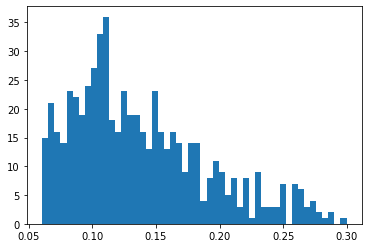

In [29]:
d_mean=[]
for dist in distances:
    d_mean.append(np.mean(dist))
plt.hist(d_mean, bins=50)

In [89]:
good_idx = np.array(good_result)[:,0].astype(int)
bad_idx = np.array(bad_result)[:,0].astype(int)
# np.random.shuffle(good_idx)

total_atoms = 0
for i in range(len(docs_test)):
    idx = i
    doc = docs_test[idx]
    sdt = SDT_test[idx]
    fixed_base = sdt[-3]
    fixed_atom_idx = np.where(fixed_base == 1)[0]
    free_atom_idx2 = np.where(fixed_base == 0)[0]
    free_atom_idx = sdt[-2]
    assert free_atom_idx2.all() == free_atom_idx.numpy().all()
    num_atoms = len(free_atom_idx)

    init = init_test[total_atoms:total_atoms+num_atoms]
    pred = pred_test[total_atoms:total_atoms+num_atoms]
    true = true_test[total_atoms:total_atoms+num_atoms]
    loss = np.mean(distance_test[total_atoms: total_atoms+num_atoms])
    total_atoms += num_atoms

    if doc['idx'] in filtered_idx:
        if doc['data'] == 'surface':
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms.write('./new_backup/traj_surface/initial/%d_%.4f_initial.traj' %(doc['idx'], loss))

            atoms_pred = copy.deepcopy(atoms)
            atoms_pred.positions[free_atom_idx] = pred
            atoms_pred.write('./new_backup/traj_surface/test/%d_%.4f_pred.traj' %(doc['idx'],loss))

        elif doc['data'] == 'slab':
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms.write('./new_backup/traj_slab/initial/%d_%.4f_initial.traj' %(doc['idx'], loss))

            atoms_pred = copy.deepcopy(atoms)
            atoms_pred.positions[free_atom_idx] = pred
            atoms_pred.write('./new_backup/traj_slab/test/%d_%.4f_pred.traj' %(doc['idx'],loss))

In [263]:
doc['idx']

2035

In [24]:
results, reduced, bad_docs, bad_result,good_docs,good_result = analysis(SDT_valid, docs_val, distance_val)

NameError: name 'distance_val' is not defined

Text(0.5, 0, '% Reduced')

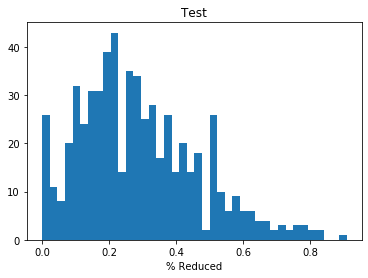

In [133]:
import matplotlib.pyplot as plt
plt.hist(reduced, bins=40)
plt.title("Test")
plt.xlabel("% Reduced")

In [22]:
docs_train[0]['data']

'slab'

In [23]:
f = []
for doc in good_docs:
    f.append(doc['data'])

In [24]:
import collections
collections.Counter(f)

Counter({'surface': 228, 'slab': 367})

In [25]:
np.mean(reduced)

0.27353239056302664

In [152]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
for doc in bad_docs:
    natoms.append(doc['atoms']['natoms'])
    types.extend(doc['atoms']['chemical_symbols'])
    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    if np.mean(dist) > 0.05:
        distances.append(dist)
        filtered_idx.append(doc['idx'])

In [153]:
d_mean=[]
for dist in distances:
    d_mean.append(np.mean(dist))
plt.hist(d_mean, bins=50)

(array([4., 2., 3., 2., 1., 4., 3., 3., 4., 1., 0., 4., 2., 2., 0., 0., 0.,
        4., 2., 2., 3., 2., 1., 1., 3., 1., 4., 2., 2., 0., 1., 0., 1., 0.,
        0., 0., 2., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 3.]),
 array([0.0617567 , 0.06603698, 0.07031727, 0.07459755, 0.07887784,
        0.08315813, 0.08743841, 0.0917187 , 0.09599898, 0.10027927,
        0.10455956, 0.10883984, 0.11312013, 0.11740042, 0.1216807 ,
        0.12596099, 0.13024127, 0.13452156, 0.13880185, 0.14308213,
        0.14736242, 0.15164271, 0.15592299, 0.16020328, 0.16448356,
        0.16876385, 0.17304414, 0.17732442, 0.18160471, 0.18588499,
        0.19016528, 0.19444557, 0.19872585, 0.20300614, 0.20728643,
        0.21156671, 0.215847  , 0.22012728, 0.22440757, 0.22868786,
        0.23296814, 0.23724843, 0.24152872, 0.245809  , 0.25008929,
        0.25436957, 0.25864986, 0.26293015, 0.26721043, 0.27149072,
        0.275771  ]),
 <a list of 50 Patch objects>)

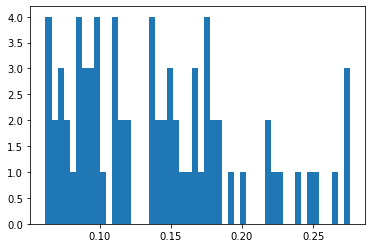

In [154]:
plt.hist(d_mean, bins=50)

(array([7., 6., 8., 2., 7., 4., 2., 2., 2., 4., 6., 2., 5., 1., 4., 4., 2.,
        1., 1., 0., 2., 2., 2., 1., 2., 3., 2., 2., 3., 1., 4., 0., 0., 1.,
        0., 0., 0., 2., 1., 1., 0., 0., 1., 0., 3., 0., 0., 1., 0., 2.]),
 array([0.04034509, 0.04505361, 0.04976213, 0.05447065, 0.05917917,
        0.06388768, 0.0685962 , 0.07330472, 0.07801324, 0.08272176,
        0.08743028, 0.09213879, 0.09684731, 0.10155583, 0.10626435,
        0.11097287, 0.11568138, 0.1203899 , 0.12509842, 0.12980694,
        0.13451546, 0.13922398, 0.14393249, 0.14864101, 0.15334953,
        0.15805805, 0.16276657, 0.16747509, 0.1721836 , 0.17689212,
        0.18160064, 0.18630916, 0.19101768, 0.19572619, 0.20043471,
        0.20514323, 0.20985175, 0.21456027, 0.21926879, 0.2239773 ,
        0.22868582, 0.23339434, 0.23810286, 0.24281138, 0.2475199 ,
        0.25222841, 0.25693693, 0.26164545, 0.26635397, 0.27106249,
        0.275771  ]),
 <a list of 50 Patch objects>)

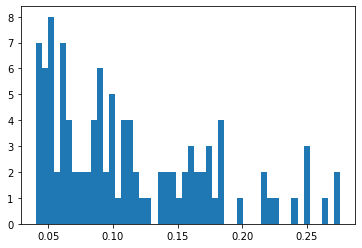

In [33]:
plt.hist(d_mean, bins=50)

In [48]:
len(distances)

158